In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, QuantileTransformer

In [2]:
train_path = "Data files/AppML_InitialProject_train.h5"
test_path = "Data files/AppML_InitialProject_test_regression.h5"
train_df = pd.read_hdf(train_path)
train_df = train_df[train_df["p_Truth_Energy"] > 0]
test_df = pd.read_hdf(test_path)
data_train = train_df.iloc[:, :-2]
data_regr_target = train_df.iloc[:, -1]
selected_features = [
    "p_pt_track",
    "pX_ecore",
    "p_eta",
    "p_sigmad0",
    "pX_deltaPhi0",
    "pX_maxEcell_energy",
    "pX_MultiLepton",
    "pX_E3x5_Lr2",
    "p_numberOfTRTXenonHits",
    "p_numberOfTRTHits",
    "pX_ptconecoreTrackPtrCorrection",
    "p_ptcone40",
    "pX_E_Lr2_HiG",
    "p_d0",
    "pX_E_Lr1_MedG",
    "p_ptPU30",
    "pX_maxEcell_z",
    "pX_topoetcone20",
    "pX_core57cellsEnergyCorrection",
    "pX_deltaPhiRescaled0",
    "pX_topoetcone40ptCorrection",
    "pX_deltaPhi2",
    "p_deltaPhiRescaled2",
    "p_dPOverP",
    "pX_nCells_Lr0_HiG",
]
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(
    data_train[selected_features], data_regr_target, test_size=0.1, random_state=42
)

scaler = QuantileTransformer()
X_train_init = scaler.fit_transform(X_train_init)
X_test_init = scaler.fit_transform(X_test_init)

In [3]:
class MyDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.input = X_data
        self.truth = y_data

    def __getitem__(self, index):
        return self.input[index], self.truth[index]

    def __len__(self):
        return len(self.input)


class MLPRegression(nn.Module):
    def __init__(self):
        super(MLPRegression, self).__init__()
        self.input_layer = nn.Linear(25, 256)
        self.hidden_layer1 = nn.Linear(256, 128)
        self.hidden_layer2 = nn.Linear(128, 64)
        self.hidden_layer3 = nn.Linear(64, 32)
        self.hidden_layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.input_layer(inputs)
        x = self.relu(x)
        x = self.hidden_layer1(x)
        x = self.relu(x)
        x = self.hidden_layer2(x)
        x = self.relu(x)
        x = self.hidden_layer3(x)
        x = self.relu(x)
        x = self.hidden_layer4(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

def Train(model, optimizer, loss_function, train_loader, validation_loader, device, epochs):
    validation_loss = []
    training_loss = []
    model.train()
    for e in range(0, epochs):
        epoch_loss = 0
        n_minibatches = 0
        for input_train_batch, truth_train_batch in train_loader:
            input_train_batch, truth_train_batch = input_train_batch.to(
                device), truth_train_batch.to(device)
            optimizer.zero_grad()
            # This asks our model to produce predictions on the training batch
            prediction = model(input_train_batch).flatten()
            # This calculates the loss
            loss = loss_function(prediction, truth_train_batch)
            # This initiates the backpropagation
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            n_minibatches += 1

        # Now that the model have trained 1 epoch, we evaluate the model on the validation set:
        valid_loss = Validate(model, validation_loader, device, loss_function)
        validation_loss.append(valid_loss)
        training_loss.append(epoch_loss/n_minibatches)
        print('EPOCH: %s | training loss: %s  | validation loss: %s' %
              (e+1, round(epoch_loss/n_minibatches, 3), round(valid_loss, 3)))
    return training_loss, validation_loss


def Validate(model, validation_loader, device, loss_function):
    model.eval()
    n_batches = 0
    validation_loss = 0
    with torch.no_grad():
        for input_valid_batch, truth_valid_batch in validation_loader:
            input_valid_batch, truth_valid_batch = input_valid_batch.to(
                device), truth_valid_batch.to(device)
            prediction = model(input_valid_batch).flatten()
            loss = loss_function(prediction, truth_valid_batch)
            validation_loss += loss.item()
            n_batches += 1
    validation_loss = validation_loss/n_batches
    return validation_loss


def Predict(model, validation_loader, device):
    model.eval()
    predictions = []
    print('PREDICTING!')
    with torch.no_grad():
        for input_pred_batch, _ in validation_loader:
            input_pred_batch = input_pred_batch.to(device)
            prediction = model(input_pred_batch)
            predictions.extend(prediction)
    print('Done Predicting!')
    return np.array(torch.FloatTensor(predictions))

In [4]:
train_data = MyDataset(torch.FloatTensor(np.array(X_train_init)),
                       torch.FloatTensor(np.array(y_train_init)))
test_data = MyDataset(torch.FloatTensor(np.array(X_test_init)),
                      torch.FloatTensor(np.array(y_test_init)))
print(train_data.input)
print(train_data.truth)

tensor([[0.6584, 0.2617, 0.4894,  ..., 0.5430, 0.7790, 0.2938],
        [0.0445, 0.9927, 0.9850,  ..., 0.1677, 0.0108, 0.0000],
        [0.1858, 0.8300, 0.0520,  ..., 0.9872, 0.9953, 0.0000],
        ...,
        [0.6941, 0.5658, 0.0758,  ..., 0.6544, 0.8717, 0.0000],
        [0.2845, 0.7711, 0.8061,  ..., 0.5847, 0.6046, 0.8864],
        [0.8407, 0.9633, 0.9832,  ..., 0.4525, 0.8895, 0.0000]])
tensor([ 26747.0566,  20203.8145,  22993.6719,  ...,  51303.9805,
         16063.8037, 151666.8594])


In [5]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
learning_rate = 1e-3
batch_size = 100
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPRegression()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

training_loss, validation_loss = Train(
    model, optimizer, loss_function, train_loader, test_loader, device, n_epochs)

EPOCH: 1 | training loss: 934025110.351  | validation loss: 492630728.753
EPOCH: 2 | training loss: 405817976.398  | validation loss: 408795471.718
EPOCH: 3 | training loss: 348958320.728  | validation loss: 371149197.835
EPOCH: 4 | training loss: 320338389.453  | validation loss: 349241239.059
EPOCH: 5 | training loss: 301825983.746  | validation loss: 334235579.247
EPOCH: 6 | training loss: 289765537.291  | validation loss: 324195918.306
EPOCH: 7 | training loss: 281185994.448  | validation loss: 315846521.953
EPOCH: 8 | training loss: 274745787.728  | validation loss: 309481824.0
EPOCH: 9 | training loss: 269297468.281  | validation loss: 304594193.929
EPOCH: 10 | training loss: 264489098.469  | validation loss: 299444082.988
EPOCH: 11 | training loss: 260116153.563  | validation loss: 295063190.706
EPOCH: 12 | training loss: 256185862.903  | validation loss: 291471664.494
EPOCH: 13 | training loss: 252462244.223  | validation loss: 287629933.765
EPOCH: 14 | training loss: 249048125

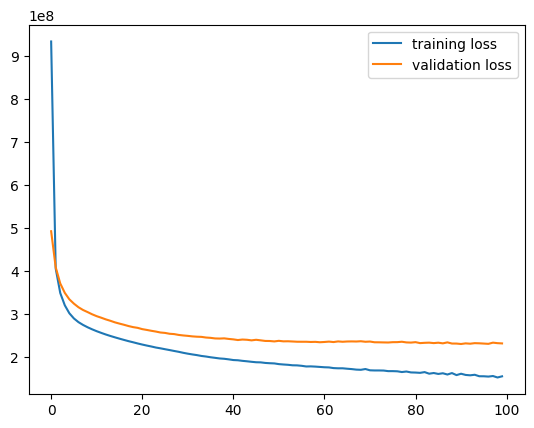

In [6]:
plt.plot(training_loss, label="training loss")
plt.plot(validation_loss, label="validation loss")
plt.legend()

In [7]:
predictions = Predict(model, test_loader, device)

PREDICTING!
Done Predicting!


In [8]:
# 0.77824193
mean_absolute_percentage_error(y_test_init, predictions)

0.77824193

In [9]:
print(predictions)

[ 19210.604 147343.9    73539.89  ...  16199.408  22146.36   43227.473]


In [10]:
y_test_init

27602      15141.255859
76273     151002.218750
10472      68137.890625
170297     15855.565430
37183      41303.816406
              ...      
109209    116063.187500
62130      15977.221680
64876      15176.331055
163421     69037.445312
10085      44028.500000
Name: p_Truth_Energy, Length: 16968, dtype: float32

(array([140., 357., 499., 523., 540., 591., 536., 541., 548., 528., 547.,
        470., 500., 456., 423., 384., 413., 388., 378., 334., 311., 275.,
        279., 302., 273., 282., 248., 220., 247., 215., 216., 203., 223.,
        200., 203., 169., 173., 151., 177., 158., 128., 118., 122., 102.,
        100.,  94.,  90.,  96.,  77.,  77.,  91.,  73.,  80.,  70.,  63.,
         61.,  66.,  49.,  64.,  57.,  37.,  58.,  50.,  43.,  39.,  31.,
         39.,  38.,  43.,  24.,  35.,  44.,  23.,  28.,  26.,  28.,  36.,
         35.,  28.,  23.,  22.,  32.,  19.,  21.,  19.,  18.,  20.,  21.,
         22.,  23.,  19.,  23.,  12.,  15.,  13.,  17.,  24.,  13.,  19.,
         13.,  22.,  13.,  23.,  14.,  14.,  17.,  13.,  10.,  12.,  10.,
          5.,  14.,  10.,  10.,   5.,  10.,  16.,   8.,  11.,   7.,   7.,
          8.,   5.,  10.,   9.,   8.,   9.,  10.,   5.,  11.,   5.,  12.,
          8.,   8.,   3.,   3.,   3.,   5.,   2.,   4.,   7.,   3.,   4.,
          7.,   4.,   5.,   6.,   6., 

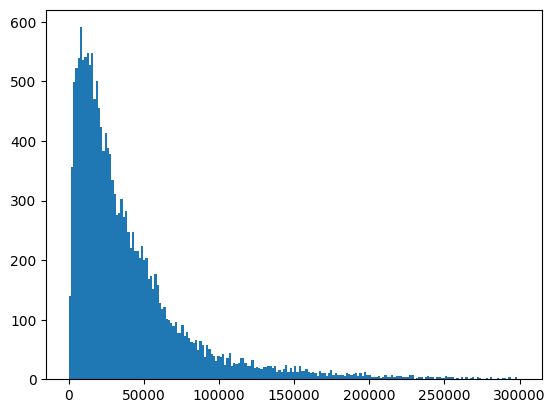

In [11]:
plt.hist(y_test_init, bins=200, range=(y_test_init.min(), 300000))

(array([299., 610., 554., 555., 557., 543., 536., 582., 563., 506., 487.,
        485., 460., 424., 405., 381., 377., 355., 344., 331., 297., 269.,
        267., 282., 262., 257., 253., 231., 229., 218., 234., 214., 184.,
        177., 207., 165., 166., 141., 134., 118., 139., 112., 107., 121.,
        115., 107., 101.,  88.,  80.,  73.,  86.,  78.,  56.,  73.,  62.,
         73.,  55.,  66.,  47.,  48.,  54.,  53.,  60.,  30.,  49.,  38.,
         52.,  33.,  44.,  25.,  35.,  33.,  30.,  31.,  33.,  38.,  27.,
         24.,  21.,  29.,  27.,  18.,  21.,  25.,  26.,  21.,  13.,  20.,
         11.,  14.,  17.,  19.,  21.,  16.,  19.,  29.,  12.,  16.,  12.,
         21.,  11.,  17.,  10.,  17.,  16.,  15.,  12.,  12.,  11.,  10.,
         12.,  19.,  10.,   7.,   7.,   5.,   7.,   2.,   8.,   5.,  11.,
         12.,   6.,   6.,   5.,   8.,   9.,   4.,   4.,  12.,   5.,   6.,
          5.,   2.,   6.,   5.,   6.,   6.,   2.,   4.,   4.,   3.,   4.,
          8.,   2.,   2.,   6.,   6., 

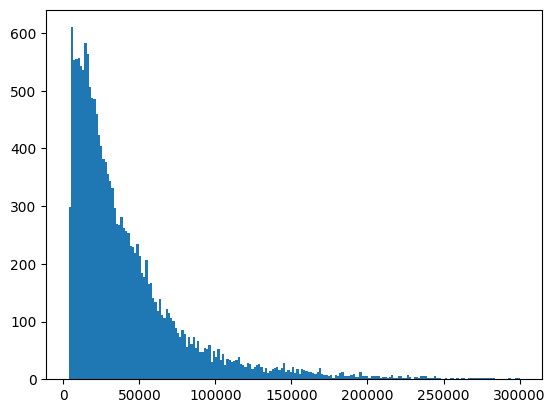

In [12]:
plt.hist(predictions, bins=200, range=(predictions.min(), 300000))

In [13]:
pred_out = (model.cpu()(torch.FloatTensor(scaler.fit_transform(np.array(
    test_df[selected_features]))).detach().cpu())).detach().numpy().flatten()

In [14]:
print(pred_out)

[12627.47  73098.805 59548.965 ... 17677.46   8642.72  15660.966]


In [15]:
# csv_out_path = "Solution_files/Regression_AliAhmad_PytorchNN.csv"
# pd.Series(pred_out).to_csv(csv_out_path, sep=",", header=None)

In [59]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {pytorch_total_params}")
# Total params: 50433

Total params: 50433
